# Predicting Subscriber Churn for a Video Streaming Platform

## Context
**AZ Watch** is a popular video streaming platform specialized in educational content, where creators publish online video tutorials and lessons about any topic.

Their next goal is to leverage AI-driven solutions to analyze and make predictions about their subscribers and improve their marketing strategy around attracting new subscribers and retaining current ones. 

## Objective
This project uses machine learning to predict subscribers likely to churn and find customer segments. This may help AZ Watch find interesting usage patterns to build subscriber personas in future marketing plans. These subscriber personas can then be used to automate targeted marketing campaigns, determine chatbot trajectories and uncover hidden target markets.

## Key Questions
- INSERT HERE !!

![Woman working on multiple screens](marketinganalytics.jpg)

## Data Overview
The `AZWatch_subscribers.csv` **dataset** contains information about subscribers and their status over the last year:

|Column name|Description|
|-----------|-----------|
|`subscriber_id`|The unique identifier of each subscriber user|
|`age_group`|The subscriber's age group|
|`engagement_time`|Average time (in minutes) spent by the subscriber per session|
|`engagement_frequency`|Average weekly number of times the subscriber logged in the platform (sessions) over a year period|
|`subscription_status`|Whether the user remained subscribed to the platform by the end of the year period (subscribed), or unsubscribed and terminated her/his services (churned)|



## Methodology
- **Preprocessing:** One-hot encoding of categorical features, standardization of numerical features
- **Models:** Logistic Regression, Random Forest, Decision Trees
- **Evaluation:** Accuracy, confusion matrices, feature importance


## Key Findings

## Notebook Structure

### How to use this notebook

# Imports

In [128]:
## Base packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
## Machine learning utilities
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
## Model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
## Model evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay

# Specify the file path of your CSV file
file_path = "data/AZWatch_subscribers.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

df.head()


,subscriber_id,age_group,engagement_time,engagement_frequency,subscription_status
0,14451,18-34,5.55,7,subscribed
1,18386,under 18,5.12,12,subscribed
2,12305,35 and over,4.25,4,churned
3,17546,18-34,8.54,15,subscribed
4,15399,18-34,12.12,20,subscribed


# Explore data

## Disaggregate by subscription status

### Overall churn and subscribe rate

(0.0, 100.0)

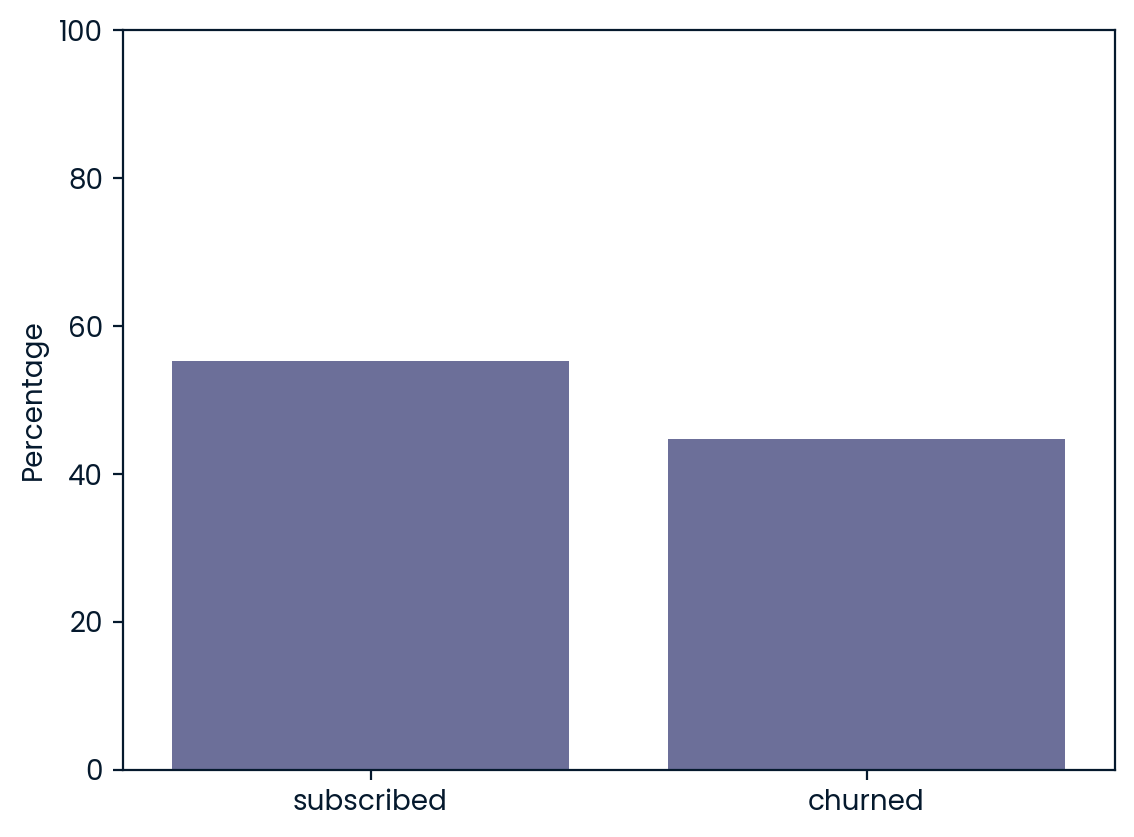

In [107]:
sns.barplot(data=df['subscription_status'].value_counts(normalize=True)*100)
plt.ylabel('Percentage')
plt.ylim(0,100)

### Distribution of engagement frequency between subscribed and churned customers

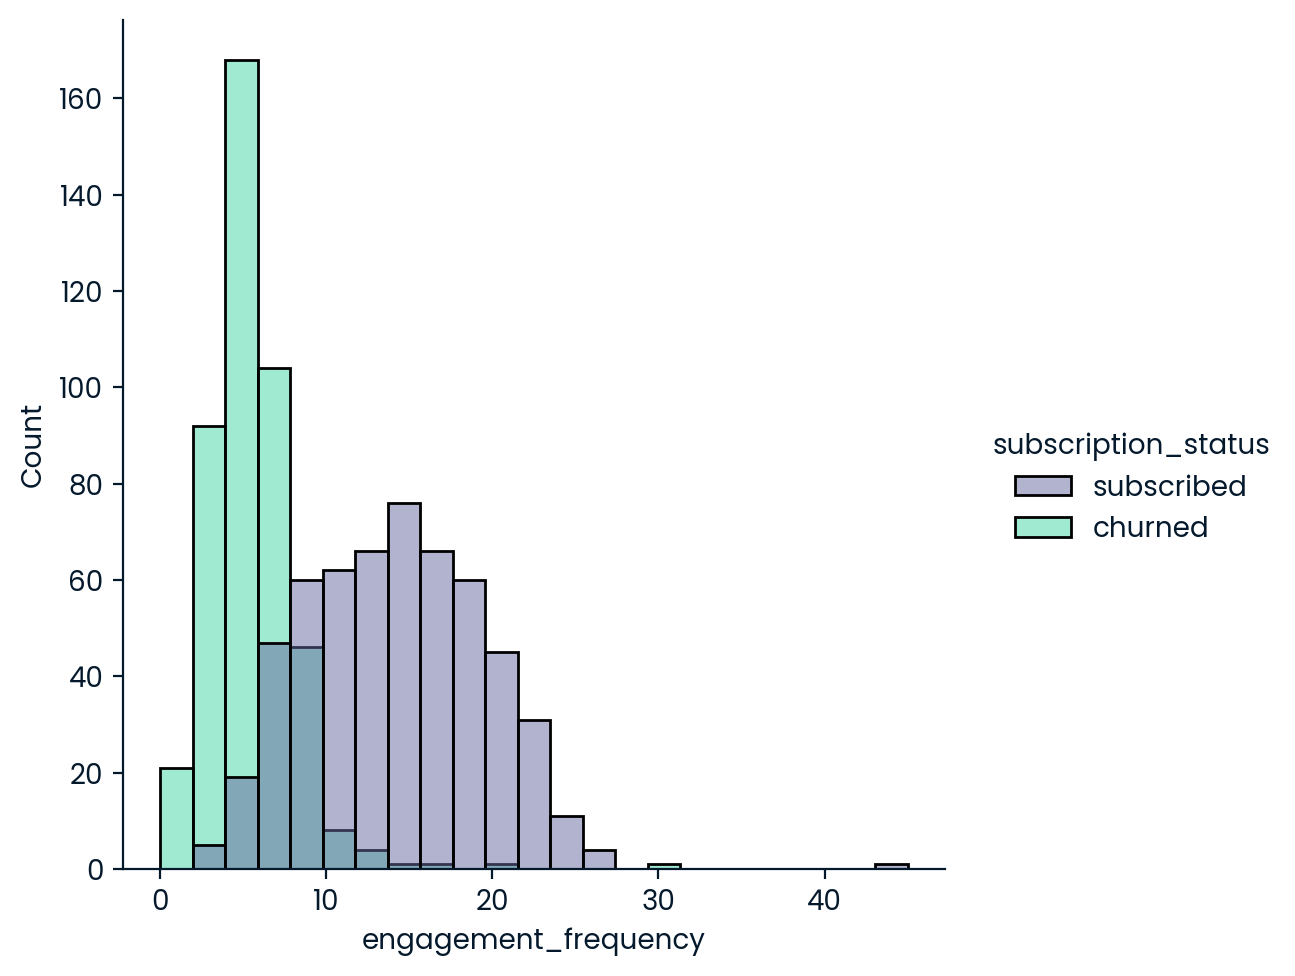

In [108]:
## Set palette to use throughout
# custom_palette = {
#     'subscribed': '#bcbddc',
#     'churned': '#a8c8c8'
# }

sns.displot(data=df, x='engagement_frequency', hue='subscription_status')

### Distribution of engagement time between subscribed and churned customers

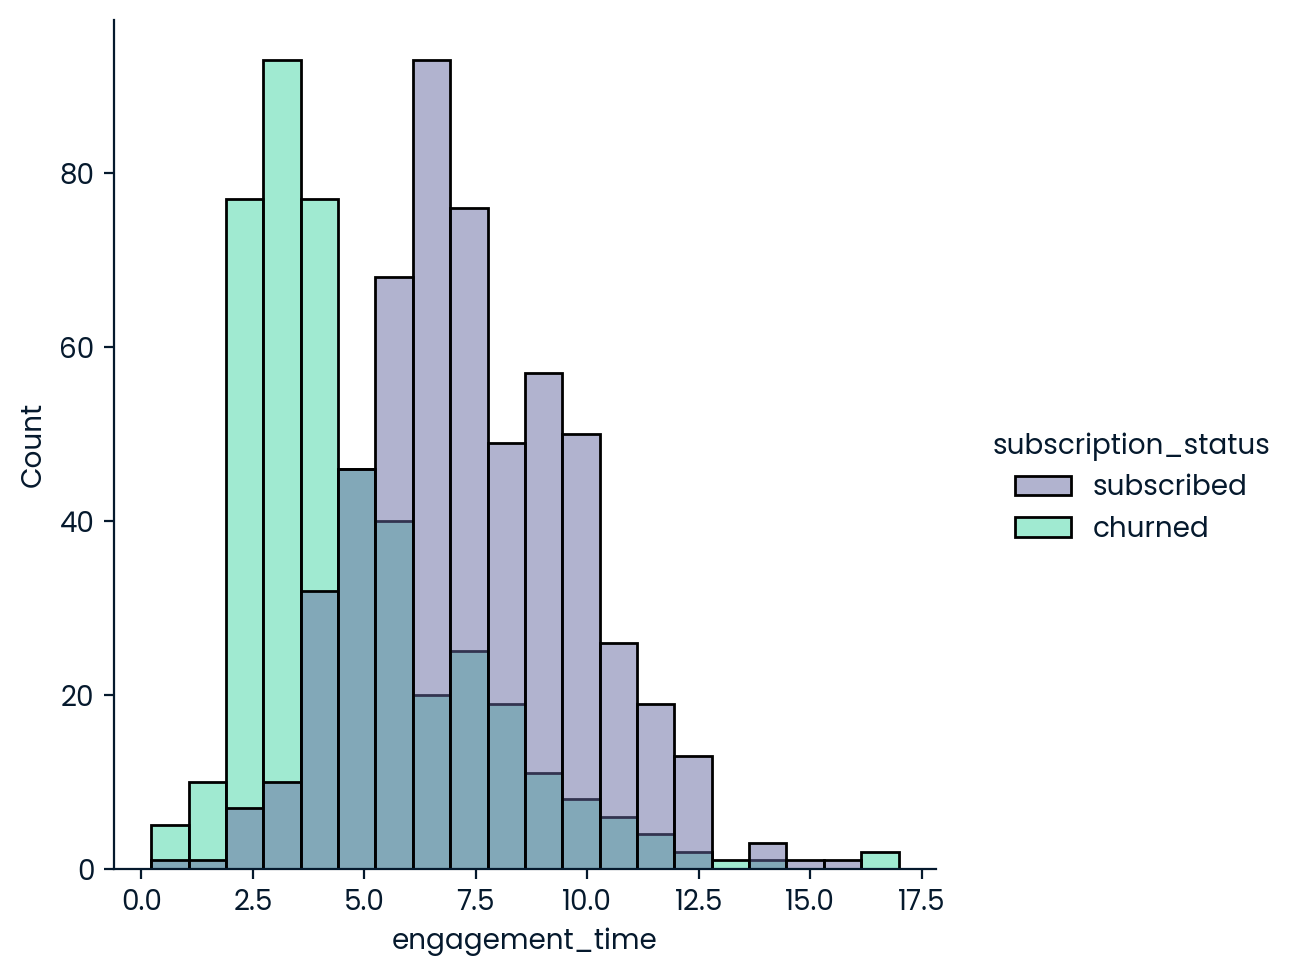

In [109]:
sns.displot(data=df, x='engagement_time', hue='subscription_status')

### Relationship between engagement frequency and time overall

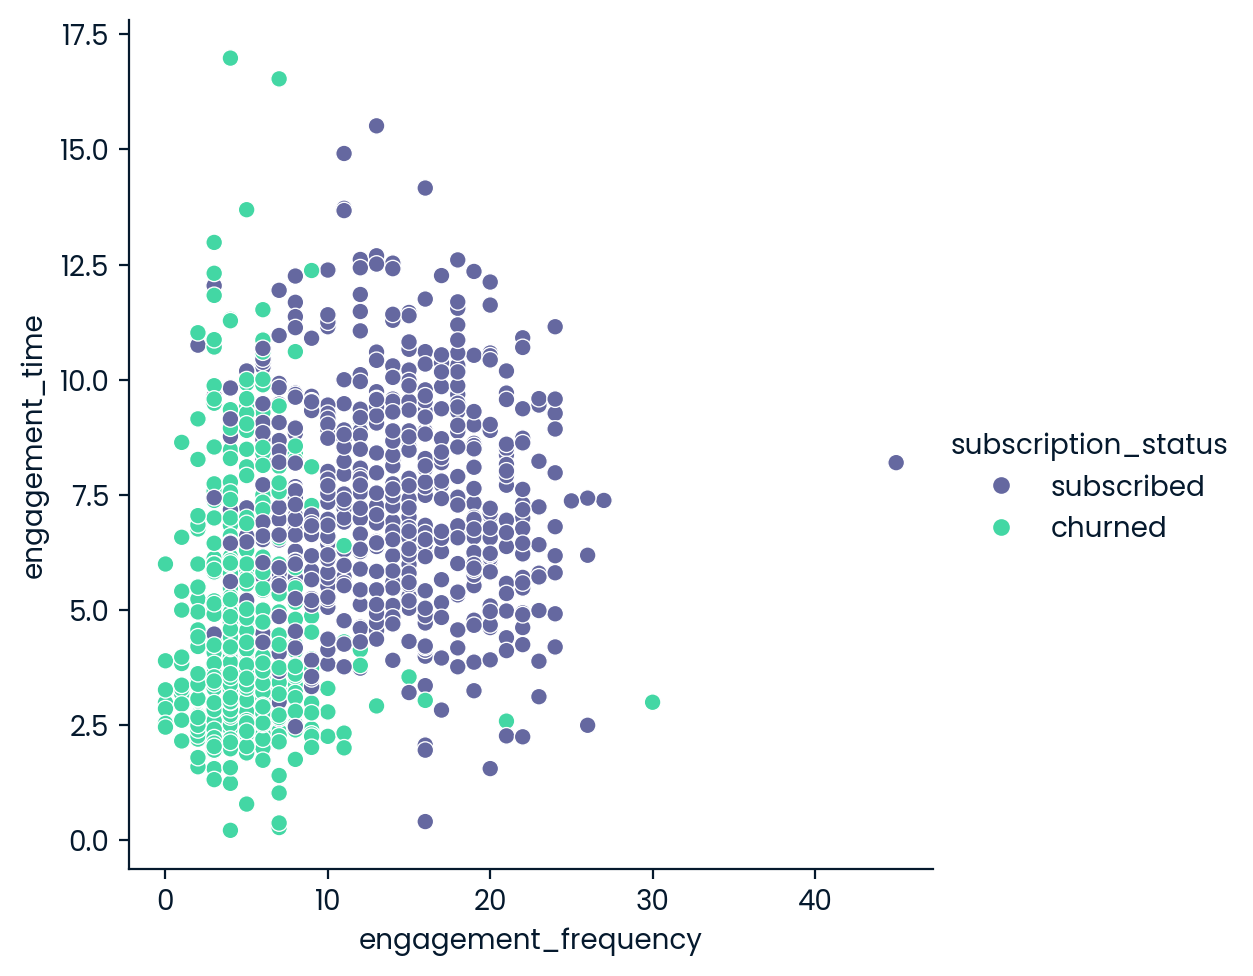

In [110]:
sns.relplot(data=df, x='engagement_frequency', y='engagement_time', hue='subscription_status')

## Disaggregate by age group and subscription status

In [111]:

# Calculate the percentage of churned/subscribed within each age group
percentage_df = (round(
    df.groupby(['age_group', 'subscription_status'])
    .size()
    .groupby(level=0)  # Group by age_group
    .apply(lambda x: 100 * x / x.sum())  # Calculate percentage
    .reset_index(name='percentage'), 2)
)
percentage_df

,age_group,subscription_status,percentage
0,18-34,churned,28.22
1,18-34,subscribed,71.78
2,35 and over,churned,58.09
3,35 and over,subscribed,41.91
4,under 18,churned,47.14
5,under 18,subscribed,52.86


In [112]:
## Define standard age group order
age_group_order = ['under 18', '18-34', '35 and over']

<AxesSubplot: xlabel='age_group', ylabel='percentage'>

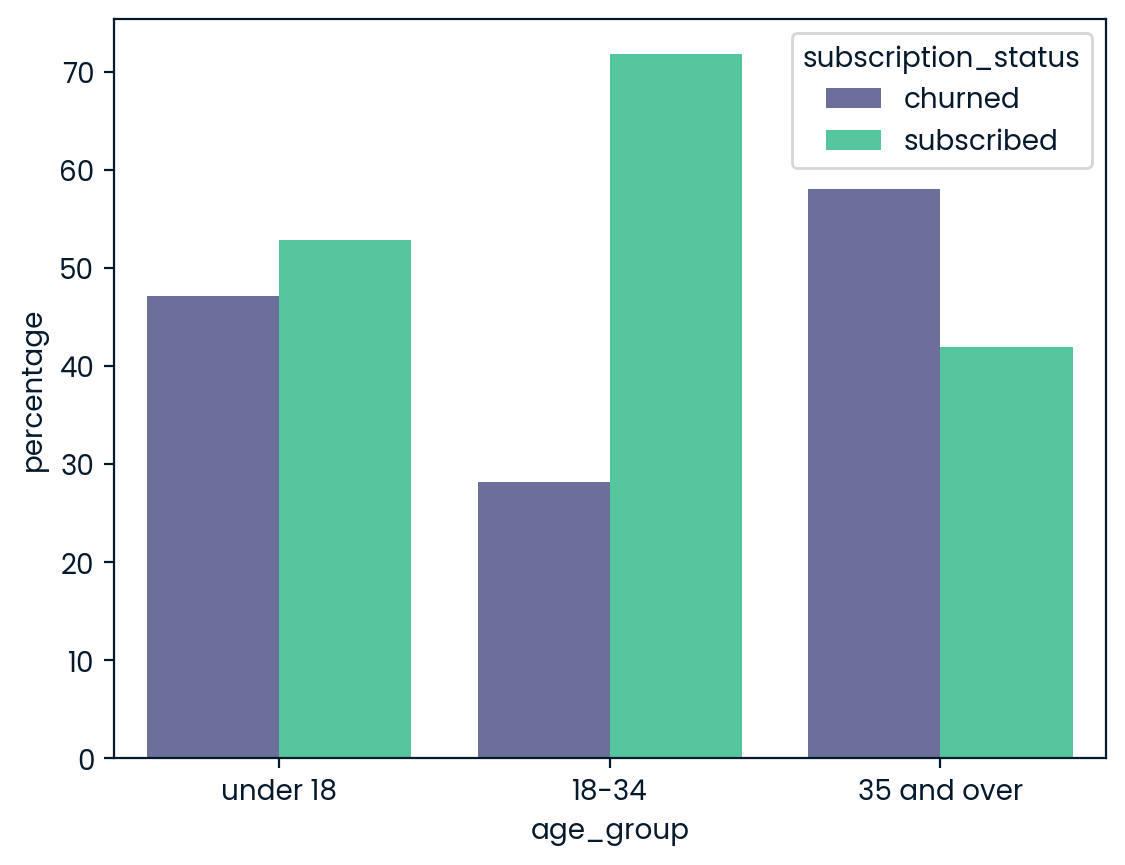

In [113]:
## Plot proportion of subscribed vs. churned by age group
sns.barplot(
    data=percentage_df,
    x='age_group',
    y='percentage',
    hue='subscription_status',
    order=age_group_order
)

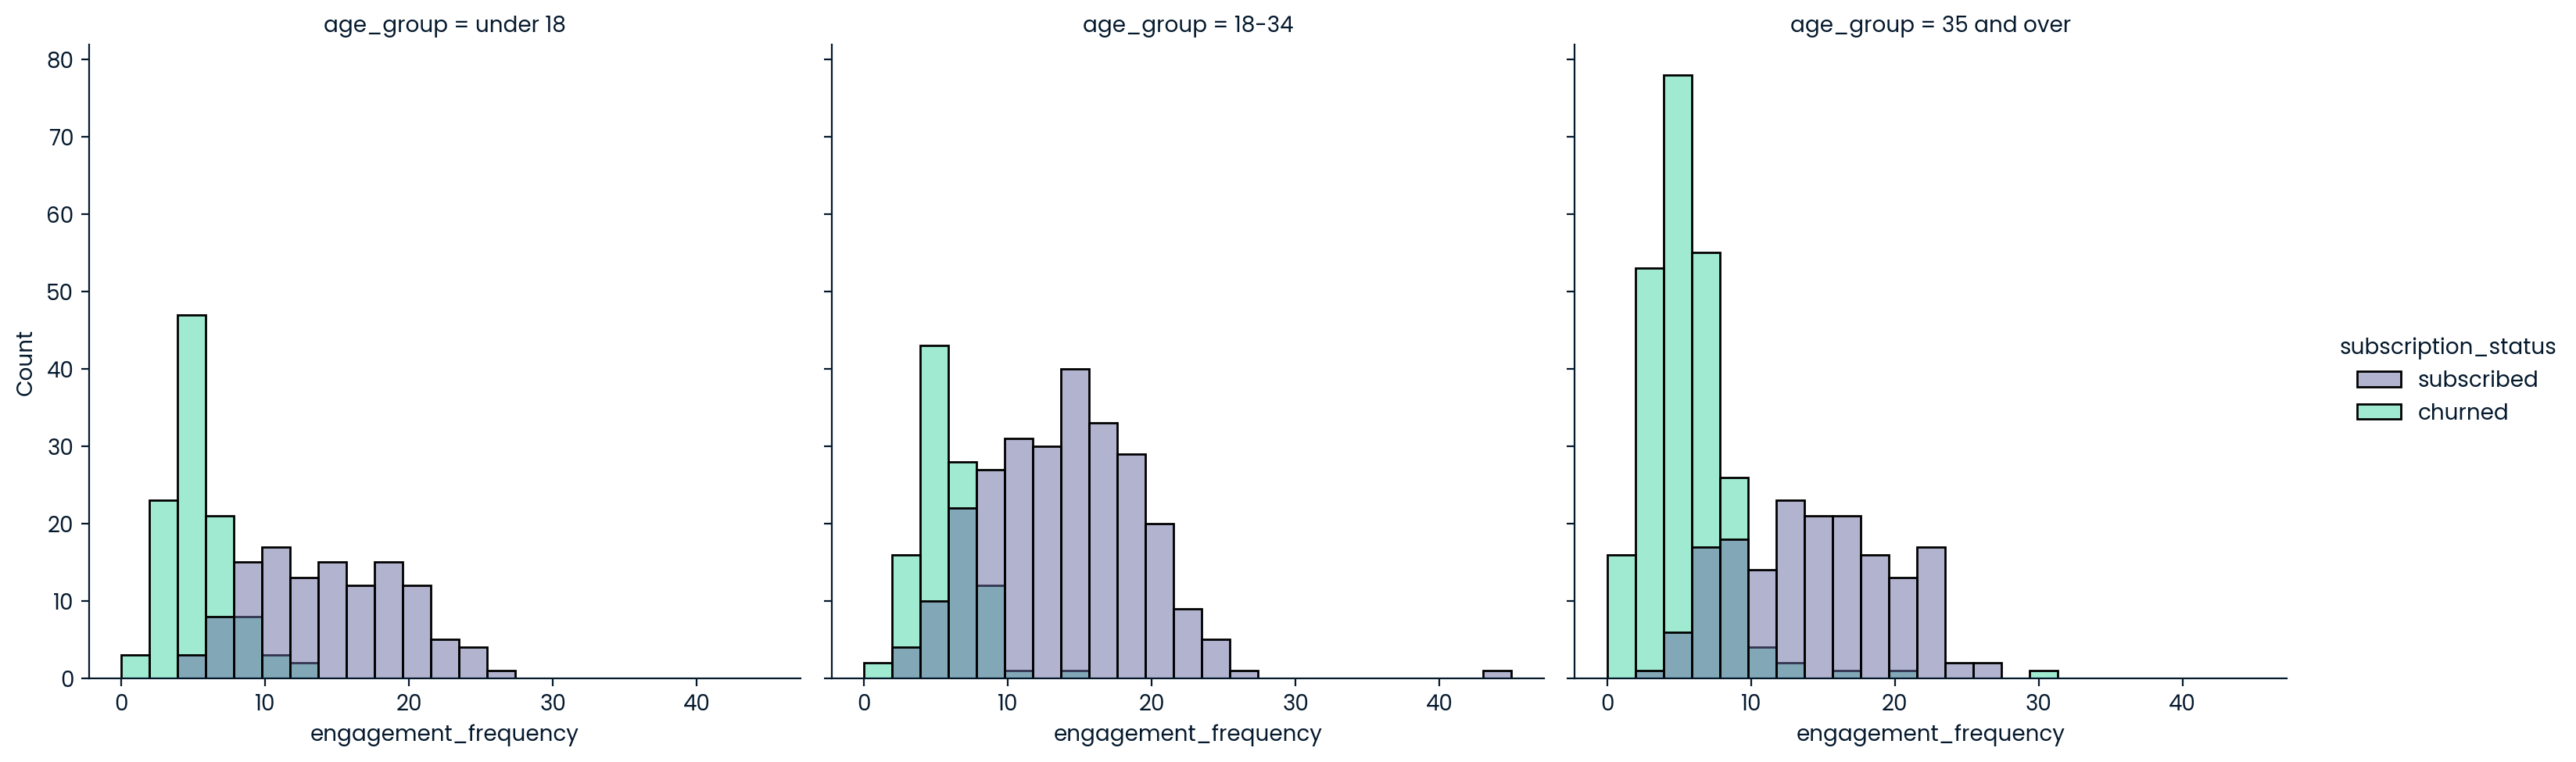

In [114]:
## Plot the distribution of engagement frequency
## Disaggregated by churn status and age group
sns.displot(data=df, x='engagement_frequency', hue='subscription_status', col='age_group', 
            col_order=age_group_order)

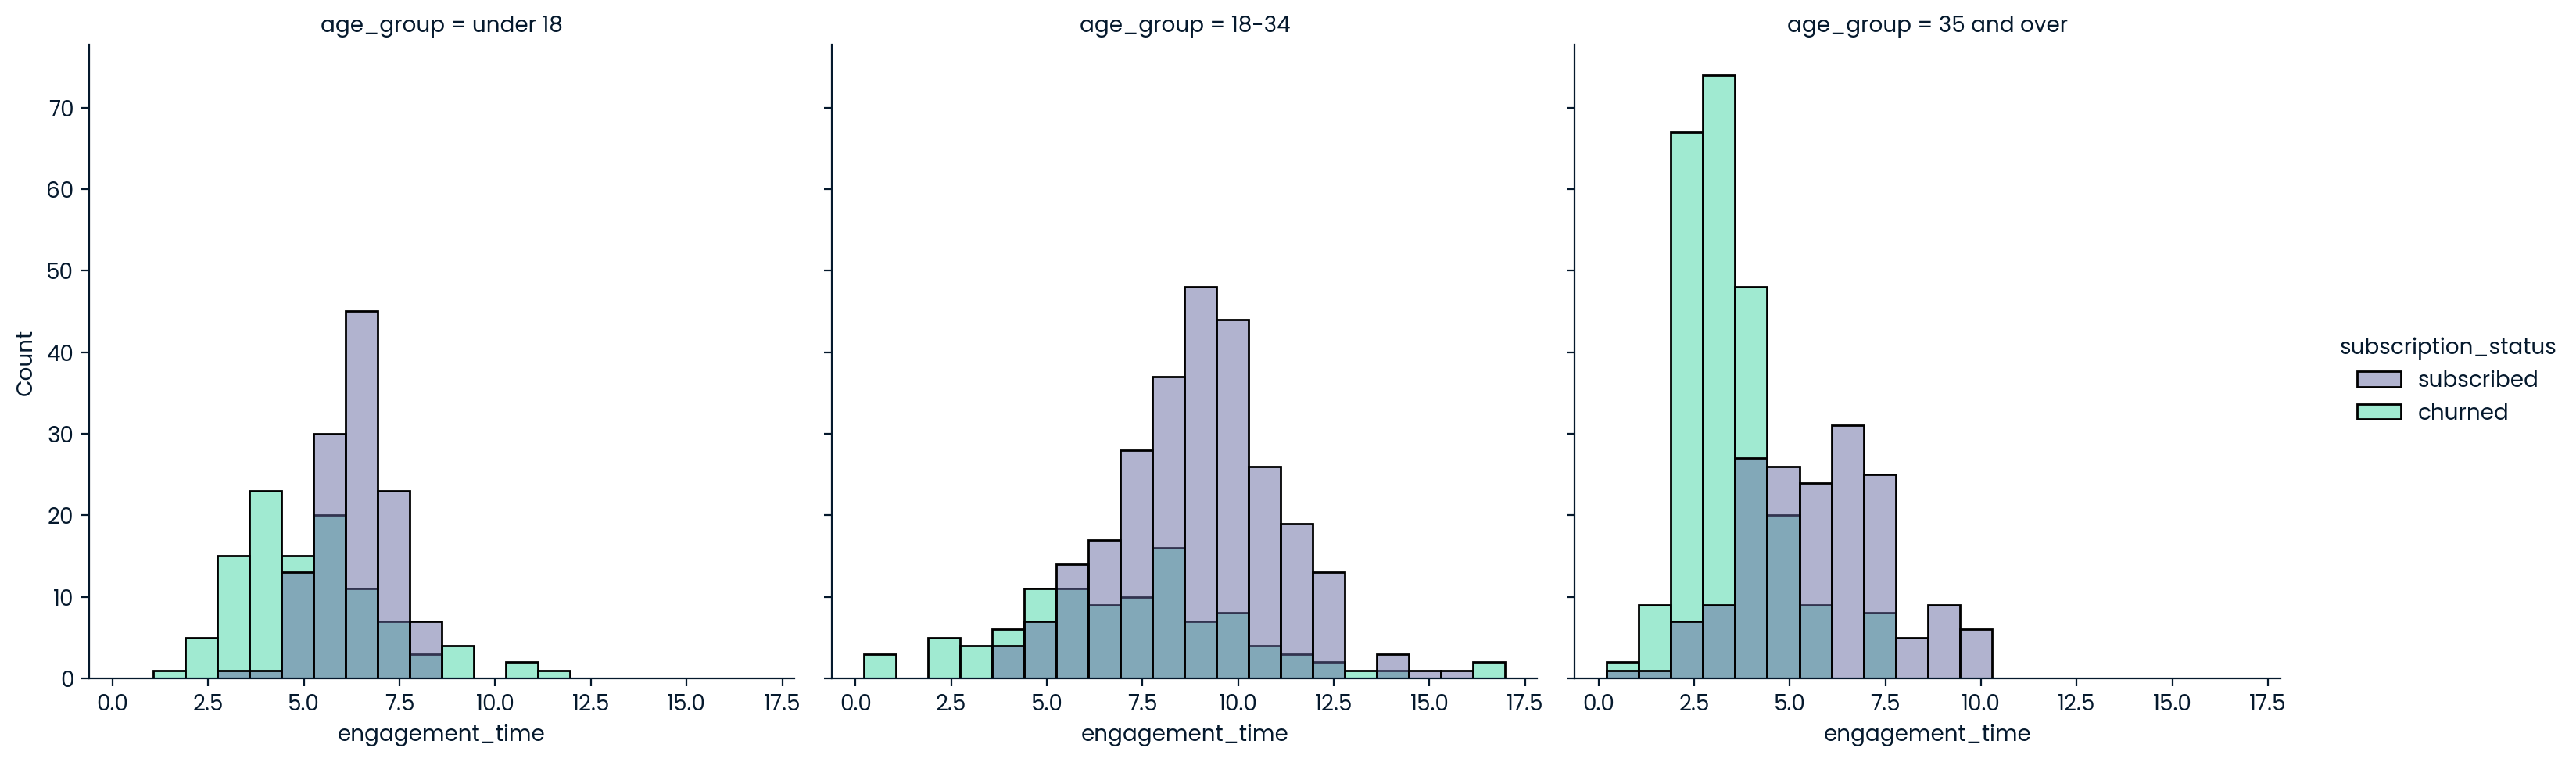

In [115]:
## Plot the distribution of engagement time
## Disaggregated by churn status and age group
sns.displot(data=df, x='engagement_time', hue='subscription_status', col='age_group', 
            col_order=age_group_order)

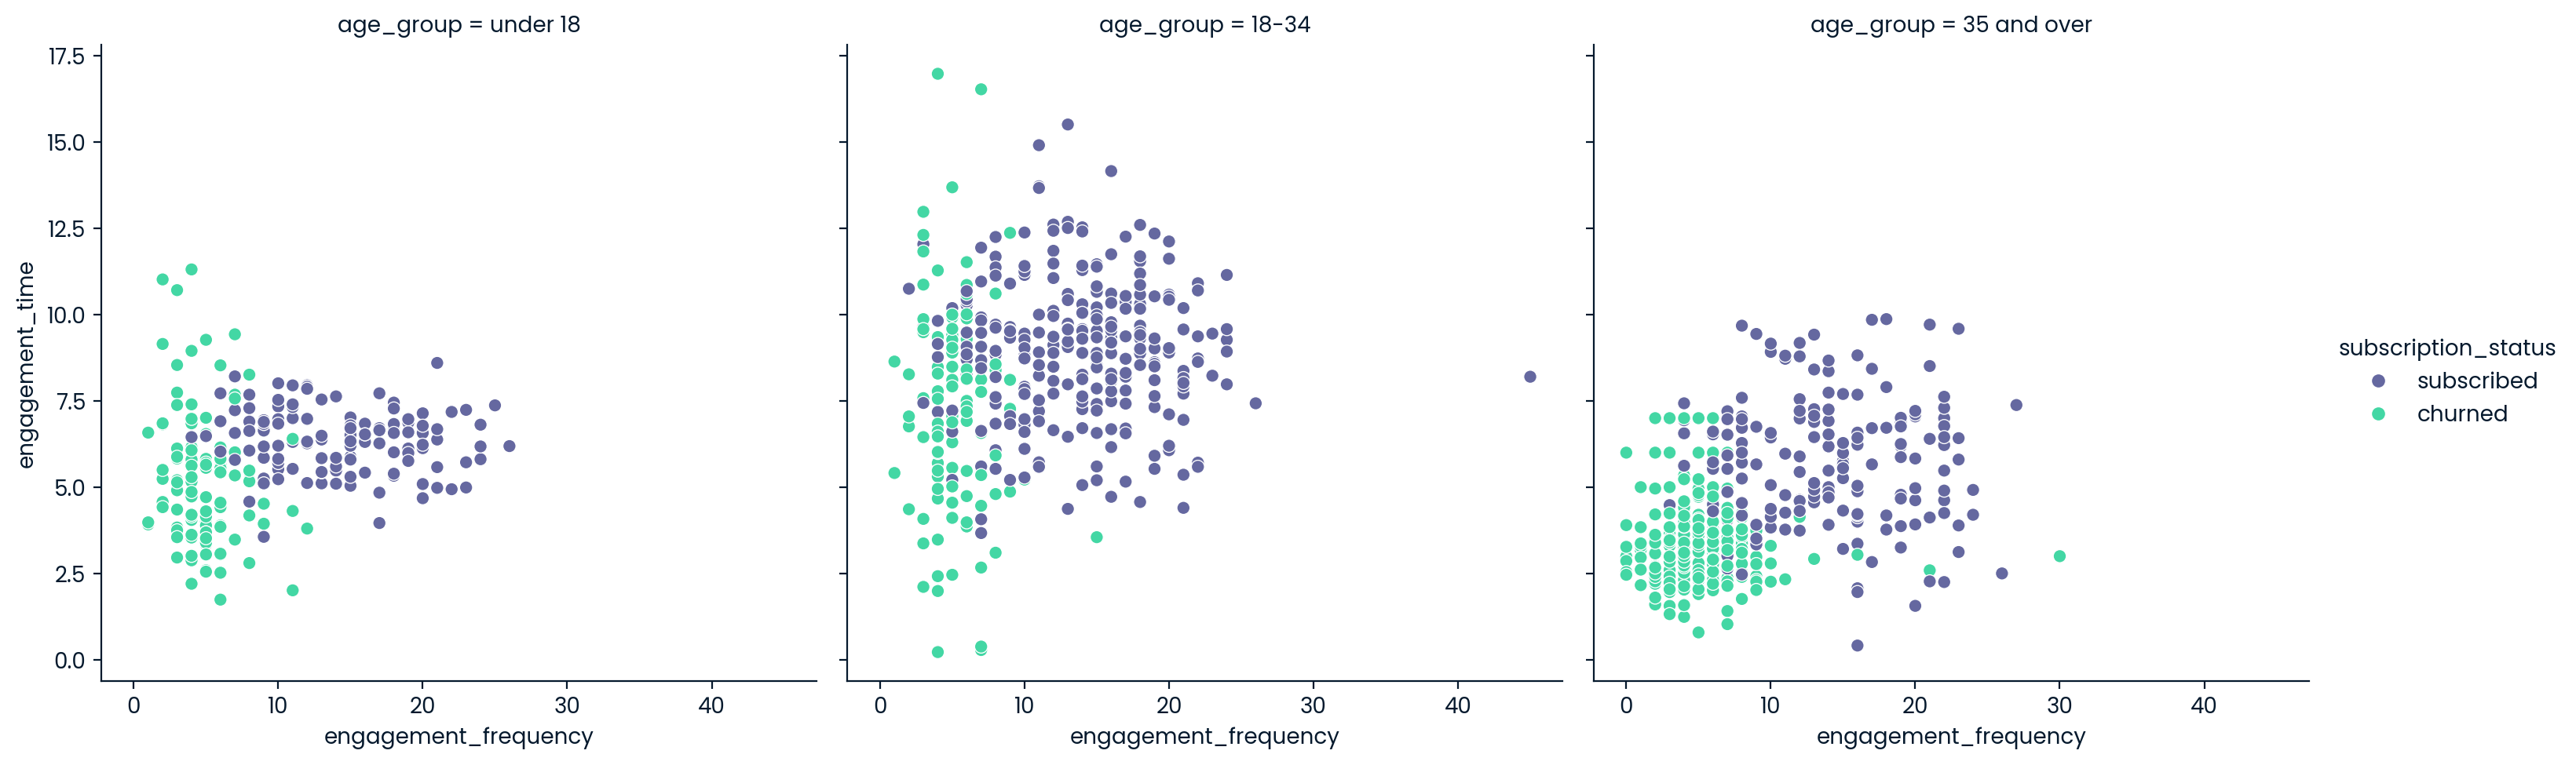

In [116]:
## Plot relationship between engagement frequency and time
## Disaggregated by churn status and age group
sns.relplot(data=df, x='engagement_frequency', y='engagement_time', hue='subscription_status', col='age_group', col_order=age_group_order)

# Split the data
Here we split the data into:
- the target variable (the customer's churned or subscribed status, indicated by y)
- the features we will use to predict the target (columns like engagement frequency, engagement time and age group, indicated by X)

Both the target and the feature are split into a train and a test set.

The train set is used to configure our model. The test set is set aside and only used to test the model once it's built.

In [117]:
## Separate predictor variables from class label
X = df.drop(['subscriber_id','subscription_status'], axis=1)
## Using map here instead of LabelEncoder to be able to customize labels for each value
y = df["subscription_status"].map({"churned": 0, "subscribed": 1})

## Split into training and test sets  
X_train, X_test, y_train, y_test = train_test_split(
                        ## Use 80/20 training/test split, fixed random state for reproducibility
                        X, y, test_size=.2, random_state=42)

X.head()

,age_group,engagement_time,engagement_frequency
0,18-34,5.55,7
1,under 18,5.12,12
2,35 and over,4.25,4
3,18-34,8.54,15
4,18-34,12.12,20


In [118]:
y.head()

0    1
1    1
2    0
3    1
4    1
Name: subscription_status, dtype: int64

# Preprocessing
It's important to always split the data BEFORE executing preprocessing steps.

This avoids "data leakage": when characteristics of the test and training data mix during preprocessing, allowing the model to 'see' the test data beforehand and artificially inflating the accuracy of the model on the test data.

<b>Preprocessing steps:</b>
- Change the categorical feature "age group" to numeric data - a series of 0's and 1's that the model can interpret
- Standardized the numeric data to have the same range and distribution

Some models work best with standardized data (such as Logistic Regression), while others don't need it and can even work better when the numeric data is left in it's natural ranges, even if they are different (liked Random Forest).

We will create two different versions of the preprocessing pipeline, one standardizing the numeric data and one without, and test how the different preprocessing steps influence the models' accuracies.

In [119]:
## Define which columns are categorical vs numeric
categorical = ["age_group"]  
numeric = ["engagement_time", "engagement_frequency"]  

## Preprocessing version 1
    ## - One hot encode categorical columns
    ## - Standardize numeric columns to same scale
preprocess1 = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", StandardScaler(), numeric),
    ],
    remainder="drop"  
)

## Preprocessing version 2
    ## - One hot encode categorical columns
    ## - Pass through numeric columns untransformed
preprocess2 = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", "passthrough", numeric),
    ],
    remainder="drop"  
)

preprocessors = {
    "preprocessing1": preprocess1,  # e.g., one-hot + standard scaling
    "preprocessing2": preprocess2   # e.g., one-hot + minmax scaling
}

# Fit models
In this section:
 1) model choices are explained
 2) each model is fit using each of the 2 preprocessing version (2 x 3 combinations)
 3) The overall accuracy for each model x preprocessing combination is calculated

## Selected models
Logistic regression, decision tree and Random Forest classifiers were chosen for their simplicity, adaptability and interpretability. The advantages and disadvantages of each are listed below.

In [120]:
## Apply each preprocessing version to each model in pipelines
models = [LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier()]

pipelines = []

## Iterate over each combination of preprocessing version and model (2x3 combinations)
for (preprocessor_name, preprocessor), model in product(preprocessors.items(), models):
    ## Set up pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    pipelines.append(pipeline)
    
    ## Fit each pipeline to training data
    pipeline.fit(X_train, y_train)
    
    ## Score each pipeline on test set
    score = pipeline.score(X_test, y_test)
    
    ## Print each preprocessor + model combo accuracy score
    print(f"{preprocessor_name} + {type(model).__name__}: {score:.4f}")

preprocessing1 + LogisticRegression: 0.9250
preprocessing1 + DecisionTreeClassifier: 0.8750
preprocessing1 + RandomForestClassifier: 0.8950
preprocessing2 + LogisticRegression: 0.9250
preprocessing2 + DecisionTreeClassifier: 0.8750
preprocessing2 + RandomForestClassifier: 0.8950


# Evaluate models
In this section:
1) each of the fitted models is evaluated for accuracy, precision, recall and f1 score
2) A confusion matrix is displayed showing the false and true positive and negative rates

## Evaluation metrics
- explain the different evaluation metrics

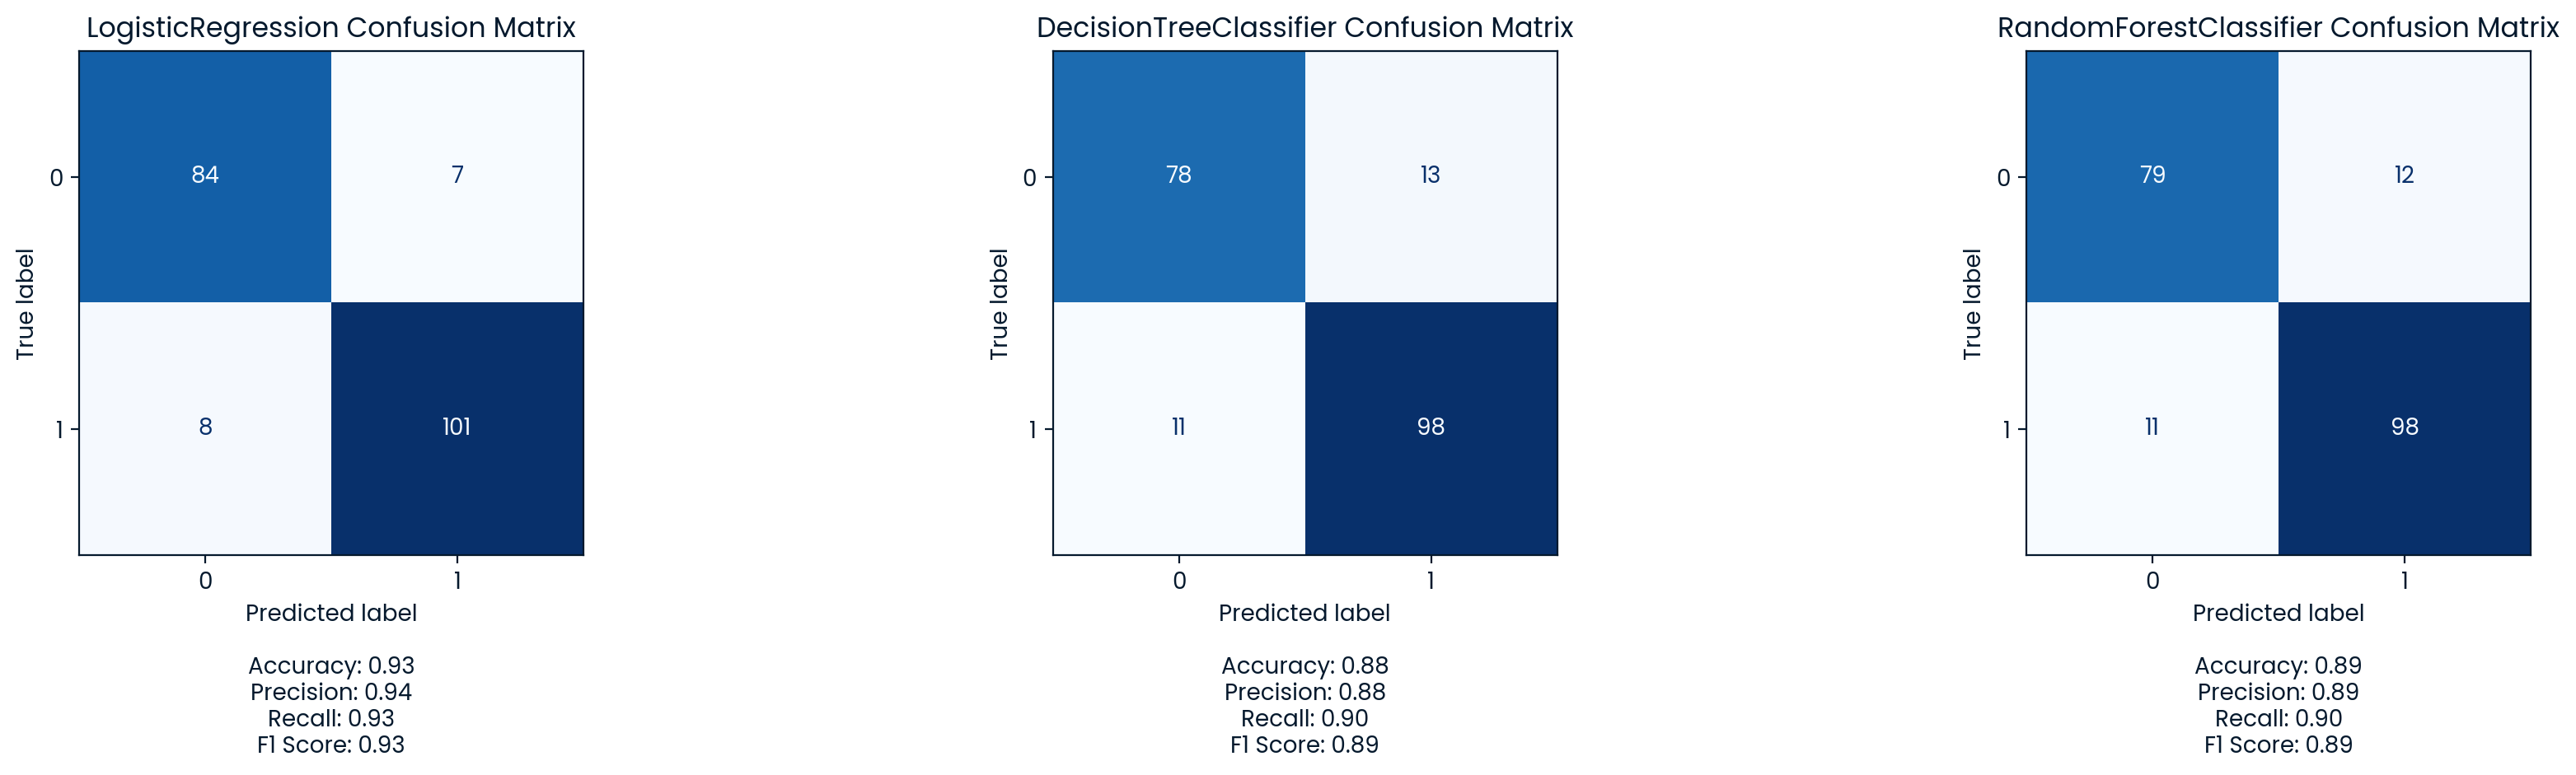

In [121]:
# Create a figure with 1 row and 3 columns for the subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loop through the models and plot the confusion matrices
for i, model in enumerate(models):
    ## Fit the model 
    pipe = Pipeline([
        ('preprocessor', preprocess2),
        ('model', model)
    ])
    pipe.fit(X_train, y_train)

    ## Get predictions
    y_pred = pipe.predict(X_test)

    ## Get the model name
    model_name = type(pipe.named_steps['model']).__name__

    ## Plot the confusion matrix
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        ax=axes[i],
        cmap='Blues',
        colorbar=False
    )

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision =precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')       
    f1 = f1_score(y_test, y_pred, average='binary')              

    # Add metrics as text below the confusion matrix
    metrics_text = (
        f"Accuracy: {accuracy:.2f}\n"
        f"Precision: {precision:.2f}\n"
        f"Recall: {recall:.2f}\n"
        f"F1 Score: {f1:.2f}"
    )
    axes[i].text(
        0.5, -0.2, metrics_text,
        ha='center', va='top',
        transform=axes[i].transAxes,
        fontsize=10
    )

    # Add the model name as the title
    axes[i].set_title(f"{model_name} Confusion Matrix")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


# Tune Models

In [122]:
## Set up param grids per model

param_grid_lr = {
    'model__C': [0.1, 1, 10],  # Regularization strength
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear', 'saga']
}

param_grid_dt = {
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__criterion': ['gini', 'entropy']
}

param_grid_rf = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10]
}

In [123]:
## Store param girds for each model
grids = [param_grid_lr, param_grid_dt, param_grid_rf]

bestparams_dict = {}

## Iterate over each model and its param grid
for m, g in zip(models, grids):
    ## Set up pipeline using best preprocdessing version
    pipeline = Pipeline([
        ('preprocessor', preprocess1),
        ('model', m)
    ])
    ## Initiate grid search cross validation with model pipeline + 5 cv splits, selecting best params by            highest accuracy
    grid_search = GridSearchCV(pipeline, g, cv=5, scoring='f1', n_jobs=-1)
    
    ## Fit to training data
    grid_search.fit(X_train, y_train)
    
    ## Display best params per model
    print(f"{type(pipeline['model']).__name__} best params: {grid_search.best_params_}")
    
    ## Store best params per model
    bestparams_dict[type(pipeline['model']).__name__] = grid_search.best_params_

LogisticRegression best params: {'model__C': 10, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
DecisionTreeClassifier best params: {'model__criterion': 'gini', 'model__max_depth': 10, 'model__min_samples_split': 10}
RandomForestClassifier best params: {'model__max_depth': 10, 'model__min_samples_split': 10, 'model__n_estimators': 200}


In [124]:
bestparams_dict.items()

dict_items([('LogisticRegression', {'model__C': 10, 'model__penalty': 'l1', 'model__solver': 'liblinear'}), ('DecisionTreeClassifier', {'model__criterion': 'gini', 'model__max_depth': 10, 'model__min_samples_split': 10}), ('RandomForestClassifier', {'model__max_depth': 10, 'model__min_samples_split': 10, 'model__n_estimators': 200})])

## Re-evaluate models

In [125]:
## Re-run models with best params

## Map model names to their class
model_classes = {
    'LogisticRegression': LogisticRegression,
    'DecisionTreeClassifier': DecisionTreeClassifier,
    'RandomForestClassifier': RandomForestClassifier 
}

# pipelines = {}

for model_name in bestparams_dict.keys():
    
    ## Create a default model
    model = model_classes[model_name]()

    ## Create the pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    ## Set the best parameters using set_params
    pipeline.set_params(**bestparams_dict[model_name])

    ## Fit the pipeline
    pipeline.fit(X_train, y_train)

    ## Sore on test set
    new_score = pipeline.score(X_test, y_test)

    ## Display new accuracies with best params
    print(f"{type(model).__name__} new accuracy: {new_score:.4f}")


LogisticRegression new accuracy: 0.9250
DecisionTreeClassifier new accuracy: 0.8900
RandomForestClassifier new accuracy: 0.9400


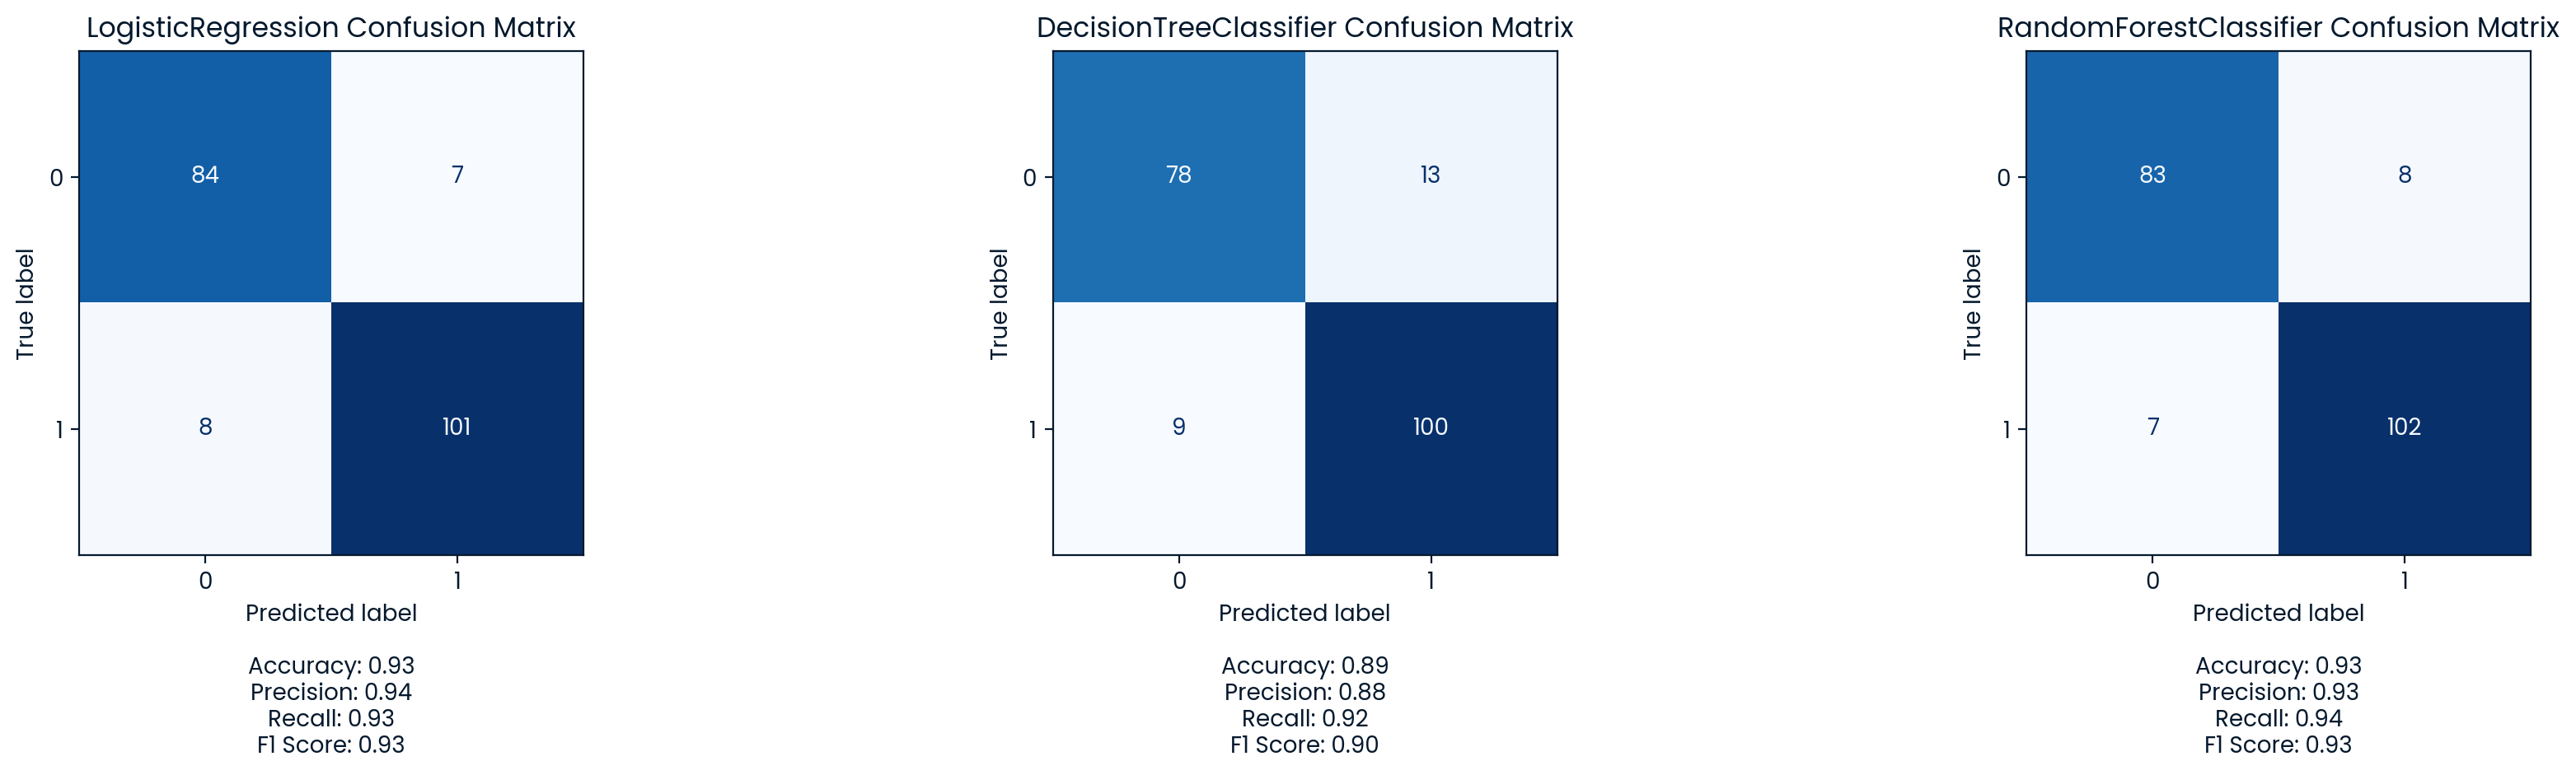

In [126]:
## Plot confusion matrices and accuracy metrics for each tuned model

## Create a figure with 1 row and 3 columns for the subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

## Loop through the models and plot the confusion matrices
for i, model in enumerate(models):
    model_name = type(model).__name__
    
    ## Fit the model 
    pipe = Pipeline([
        ('preprocessor', preprocess1),
        ('model', model)
    ])

    pipe.set_params(**bestparams_dict[model_name])
    
    pipe.fit(X_train, y_train)

    ## Get predictions
    y_pred = pipe.predict(X_test)

    ## Get the model name
    model_name = type(pipe.named_steps['model']).__name__

    ## Plot the confusion matrix
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        ax=axes[i],
        cmap='Blues',
        colorbar=False    
    )

     # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision =precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')       
    f1 = f1_score(y_test, y_pred, average='binary')              

    # Add metrics as text below the confusion matrix
    metrics_text = (
        f"Accuracy: {accuracy:.2f}\n"
        f"Precision: {precision:.2f}\n"
        f"Recall: {recall:.2f}\n"
        f"F1 Score: {f1:.2f}"
    )
    axes[i].text(
        0.5, -0.2, metrics_text,
        ha='center', va='top',
        transform=axes[i].transAxes,
        fontsize=10
    )
    
    ## Add the model name as the title
    axes[i].set_title(f"{model_name} Confusion Matrix")

## Adjust layout and show the plot
plt.tight_layout()
plt.show()


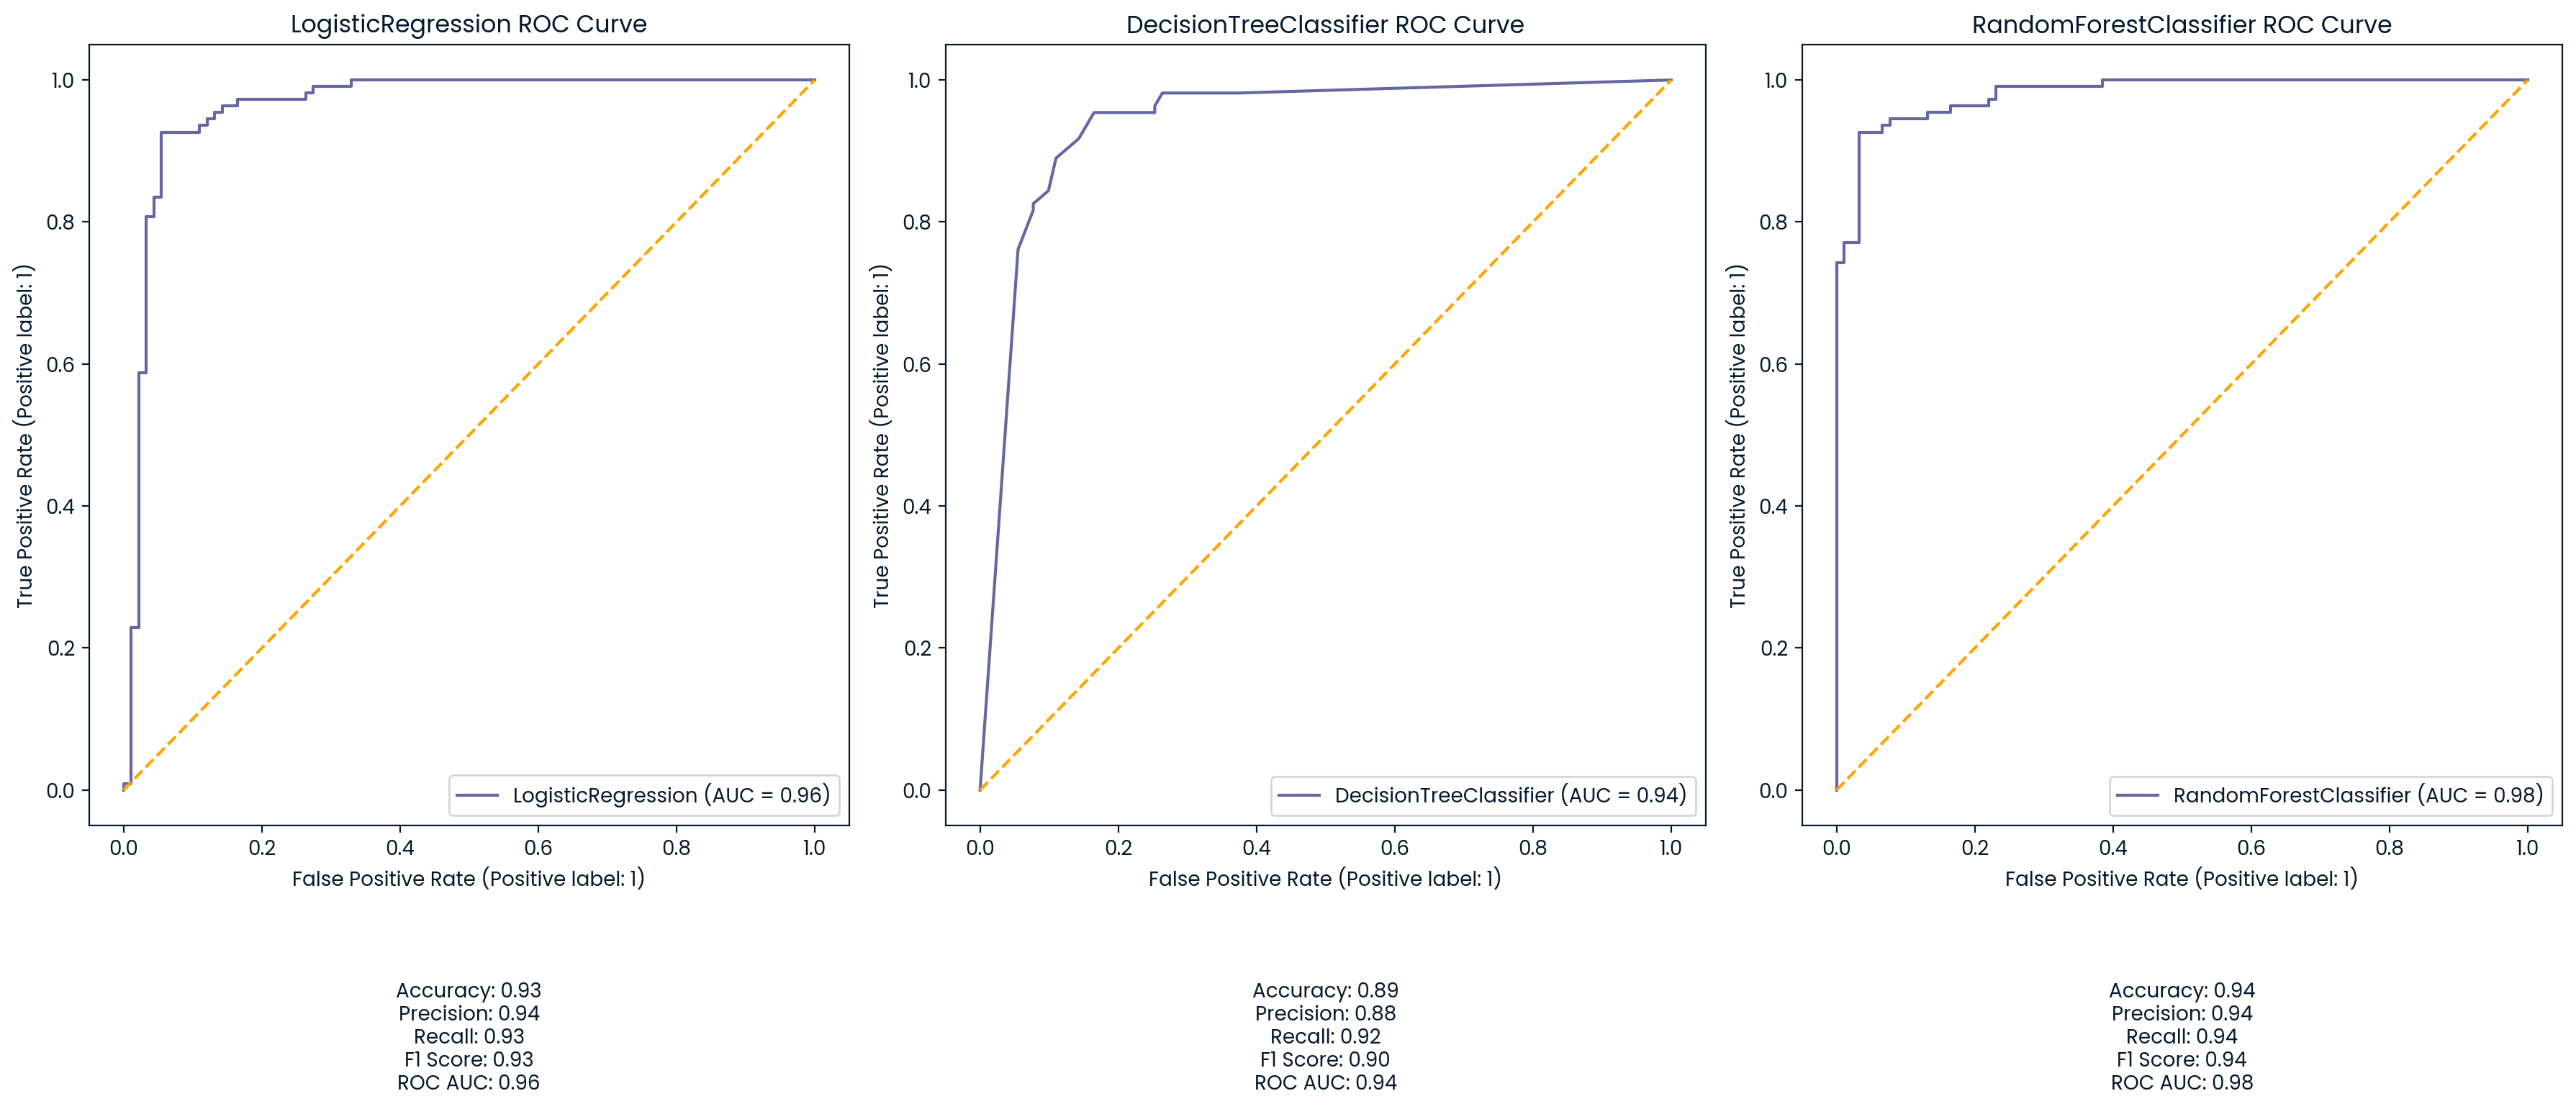

In [130]:
## Plot Receiver Operating Curve (ROC) for each tuned model

# Create a figure with 1 row and 3 columns for the subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

# Loop through the models and plot the ROC curves
for i, model in enumerate(models):
    model_name = type(model).__name__

    ## Fit the model
    pipe = Pipeline([
        ('preprocessor', preprocess1),
        ('model', model)
    ])

    if model_name in bestparams_dict:
        pipe.set_params(**bestparams_dict[model_name])

    pipe.fit(X_train, y_train)

    ## Get predicted probabilities for ROC curve
    y_proba = pipe.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

    ## Plot the ROC curve
    RocCurveDisplay.from_estimator(
        pipe,
        X_test,
        y_test,
        ax=axes[i],
        name=model_name
    )

    # Calculate metrics
    y_pred = pipe.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    roc_auc = roc_auc_score(y_test, y_proba)

    # Add metrics as text below the ROC curve
    metrics_text = (
        f"Accuracy: {accuracy:.2f}\n"
        f"Precision: {precision:.2f}\n"
        f"Recall: {recall:.2f}\n"
        f"F1 Score: {f1:.2f}\n"
        f"ROC AUC: {roc_auc:.2f}"
    )
    axes[i].text(
        0.5, -0.2, metrics_text,
        ha='center', va='top',
        transform=axes[i].transAxes,
        fontsize=10
    )

    ## Add the model name as the title
    axes[i].set_title(f"{model_name} ROC Curve")
    axes[i].plot([0, 1], [0, 1], linestyle='--', color='orange')  # Add diagonal line for reference

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


## Final model selection
- select best model
- explain choice
- explain trade-off between precision and recall between top 2 models

# Establish churn risk factors: Feature Importance

- perform feature selection on top model to evaluate churn risk factors

# Trade-offs: Accuracy vs. Interpretability

- discuss trade-off between high accuracy/f1 and interpretability
- visualize decision tree to illustrate point
- compare to the visualization options for the others

# Customer Segmentation

In [14]:

sse = []

## record the SSE for each value of k
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='random', n_init=20, random_state=42)
    kmeans.fit(scaled_numeric)
    sse.append(kmeans.inertia_)

## visualize results
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

NameError: name 'scaled_numeric' is not defined

In [16]:
#instantiate the k-means class, using optimal number of clusters
kmeans = KMeans(init="random", n_clusters=3, n_init=20, random_state=1)

#fit k-means algorithm to data
kmeans.fit(scaled_numeric)

#view cluster assignments for each observation
kmeans.labels_
 

array([2, 1, 0, 2, 2, 2, 1, 1, 0, 0, 0, 2, 0, 2, 0, 2, 1, 0, 1, 0, 0, 0,
       0, 1, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 1, 0, 0, 1, 0, 2, 1, 1, 0, 0,
       0, 0, 2, 1, 0, 2, 1, 0, 0, 0, 1, 2, 1, 0, 2, 1, 1, 0, 1, 1, 2, 2,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 2, 0, 1, 0, 1, 2, 1, 1, 1, 0, 0, 2, 2,
       1, 0, 2, 0, 2, 0, 1, 2, 0, 2, 2, 2, 0, 0, 0, 1, 2, 0, 0, 0, 2, 2,
       0, 2, 0, 1, 2, 2, 0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 1, 0, 0, 2, 1, 1,
       0, 2, 2, 1, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 1, 0, 1, 1,
       0, 2, 0, 1, 2, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       2, 2, 2, 0, 2, 1, 0, 0, 1, 1, 0, 0, 0, 2, 0, 2, 1, 0, 2, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 1, 1, 2, 1, 1, 1, 0, 0, 1,
       1, 2, 0, 2, 2, 1, 0, 0, 1, 2, 2, 1, 2, 0, 0, 0, 2, 1, 1, 0, 2, 2,
       1, 2, 0, 0, 0, 1, 1, 2, 0, 1, 2, 0, 0, 0, 2, 1, 2, 2, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 2, 1, 2, 2, 2,

In [24]:
#append cluster assingments to original DataFrame
df['cluster'] = kmeans.labels_

print(df['cluster'].shape[0])
#view updated DataFrame
df.head()

1000


,subscriber_id,age_group,engagement_time,engagement_frequency,subscription_status,agegroup_onehot,subcription_code,subscription_code,cluster
0,14451,18-34,5.55,7,subscribed,0,1,1,2
1,18386,under 18,5.12,12,subscribed,2,1,1,1
2,12305,35 and over,4.25,4,churned,1,0,0,0
3,17546,18-34,8.54,15,subscribed,0,1,1,2
4,15399,18-34,12.12,20,subscribed,0,1,1,2


In [34]:
## find averages by cluster id

mode = lambda x: x.mode().iloc[0]

cluster_metrics = round(df[['agegroup_onehot','engagement_time', 'engagement_frequency', 'subscription_code', 'cluster']].groupby(by='cluster').agg(
    {"agegroup_onehot": mode,
    "subscription_code": mode,
    "engagement_time":"mean",
    "engagement_frequency":'mean'
      }
), 0)

cluster_metrics

,agegroup_onehot,subscription_code,engagement_time,engagement_frequency
cluster,,,,
0,1,0,4.0,5.0
1,1,1,6.0,14.0
2,0,1,9.0,13.0
